In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split


In [ ]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
# hyperparameters
max_length = 88
batch_size = 64
dev_size = 0.2

In [ ]:
# Bert Tokenizer
model_name = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
train_df = pd.read_csv('Hi-En train.csv')

In [ ]:
train_df.head()

,article_link,is_sarcastic,headline
0,0,0,ather farouqui general secretary of ghar empha...
1,1,0,by passing of is started ji jaggo nahi to sama...
2,2,1,swadu duniya geeta parjapat manjeetgill royal ...
3,3,1,hurry up kahin ye offer miss na ho jaye p p p p p
4,4,1,s logic hasne ke paise milte hai to alag alag ...


In [ ]:
train_df.rename(columns = {'Unnamed: 0':'id'}, inplace = True)
train_df.head()

,article_link,is_sarcastic,headline
0,0,0,ather farouqui general secretary of ghar empha...
1,1,0,by passing of is started ji jaggo nahi to sama...
2,2,1,swadu duniya geeta parjapat manjeetgill royal ...
3,3,1,hurry up kahin ye offer miss na ho jaye p p p p p
4,4,1,s logic hasne ke paise milte hai to alag alag ...


In [ ]:
train, dev = train_test_split(train_df, test_size=dev_size, random_state=42)

In [ ]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [ ]:
train

,article_link,is_sarcastic,headline
110042,110042,1,kyu bhai kyu
69993,69993,0,aap log nagrikta bill ka virodh kar rahe ho ya...
4199,4199,1,kumbhkaran was a nice man achcha bura sab pata...
49205,49205,1,eliseee dying soo momma said i can stay home t...
41055,41055,0,calling atk as amar tomar kolkata is like the ...
...,...,...,...
76820,76820,1,replying to prayag
110268,110268,1,yay i find out how i did on my physics midterm...
103694,103694,1,maaf kardo yaar bechare ko
860,860,0,mumbai is the financial capital yet its floode...


In [ ]:
train_encoded = bert_encode(train.headline)
dev_encoded = bert_encode(dev.headline)


train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, train.is_sarcastic))
    .shuffle(100)
    .batch(batch_size)
)

dev_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dev_encoded, dev.is_sarcastic))
    .shuffle(100)
    .batch(batch_size)
)

In [ ]:
def bert_tweets_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]    
    x = tf.keras.layers.LSTM(100, dropout=0.3, recurrent_dropout=0.3)(last_hidden_states)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=output)
    
    return model

In [ ]:
with strategy.scope():
    model = bert_tweets_model()
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss='binary_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

    model.summary()

Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 88)]              0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  167356416
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             88, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [ ]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=2,
    validation_data=dev_dataset,
    verbose=2)
    #callbacks=[tf.keras.callbacks.EarlyStopping(
    #            patience=6,
    #            min_delta=0.05,
    #            baseline=0.7,
    #            mode='min',
    #            monitor='val_accuracy',
    #            restore_best_weights=True,
    #            verbose=1)
    #          ])

Epoch 1/2
1438/1438 - 2330s - loss: 0.3127 - accuracy: 0.8735 - val_loss: 0.2920 - val_accuracy: 0.8872 - 2330s/epoch - 2s/step
Epoch 2/2
1438/1438 - 2319s - loss: 0.2641 - accuracy: 0.8937 - val_loss: 0.2735 - val_accuracy: 0.8900 - 2319s/epoch - 2s/step


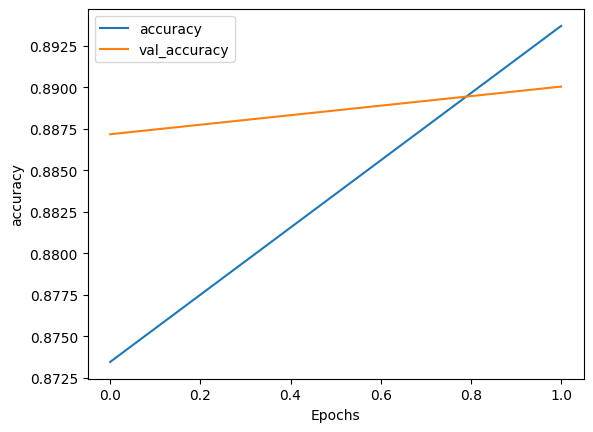

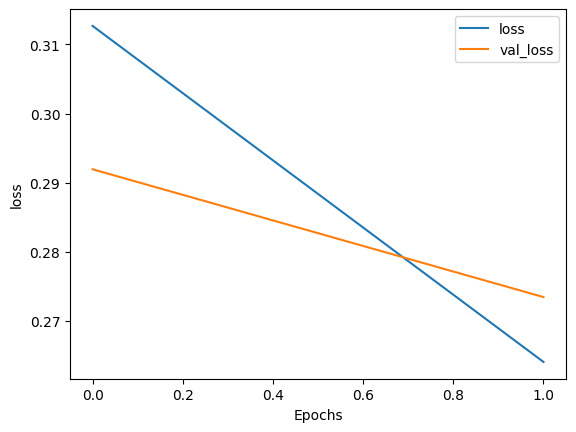

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
test, val = train_test_split(dev, test_size=dev_size, random_state=42)

In [ ]:
dev.shape

(23000, 3)

In [ ]:
test.head()

,article_link,is_sarcastic,headline
74639,74639,0,ind oho aap log phir chalu hogaye ki lene main...
85919,85919,0,love is in the hair kyuki abhi ke ladko ko baa...
70742,70742,1,takut nak permainkan perasaan orang sebabkan k...
31906,31906,0,good to see players taking a stand against the...
16370,16370,1,mohabbat aur naukri ek jaisi hoti hai log kart...


In [ ]:
test_encoded = bert_encode(dev.headline)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_encoded)
    .batch(batch_size)
)

predicted_tweets = model.predict(test_dataset, batch_size=batch_size)
predicted_tweets_binary = tf.cast(tf.round(predicted_tweets), tf.int32).numpy().flatten()
print(predicted_tweets_binary)

360/360 [==============================] - 143s 386ms/step
[1 0 0 ... 1 0 1]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [ ]:
print("Bert+LSTM")
print("Accuracy score =", accuracy_score(dev['is_sarcastic'], predicted_tweets_binary))
print(metrics.classification_report(dev['is_sarcastic'], predicted_tweets_binary))


Bert+LSTM
Accuracy score = 0.8900434782608696
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     11414
           1       0.92      0.86      0.89     11586

    accuracy                           0.89     23000
   macro avg       0.89      0.89      0.89     23000
weighted avg       0.89      0.89      0.89     23000



In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import string

def preprocess_data(text: str) -> str:
   return text.lower().translate(str.maketrans("", "", string.punctuation)).strip()

MODEL_PATH = "helinivan/english-sarcasm-detector"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

text = "what are you doing"
tokenized_text = tokenizer([preprocess_data(text)], padding=True, truncation=True, max_length=256, return_tensors="pt")
output = model(**tokenized_text)
probs = output.logits.softmax(dim=-1).tolist()[0]
confidence = max(probs)
prediction = probs.index(confidence)
results = {"is_sarcastic": prediction, "confidence": confidence}

In [ ]:
print(results)

{'is_sarcastic': 0, 'confidence': 0.9509801268577576}
